## Question 2: Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

1. Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).


2. Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.



In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
#import matplotlib.pyplot as plt
%pylab inline

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV ,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix



Populating the interactive namespace from numpy and matplotlib


In [4]:
#We fix a seed for the rest of the code
seed = 1


In [5]:
#We load the "20newsgroup" dataset
ng = fetch_20newsgroups(subset = 'all')

#Extract the features
x = ng.data
#Extract the targets 
y = ng.target
#Extract the names of the targets
names = ng.target_names


In [6]:
#We split our dataset into subsets.
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.1, random_state=3, stratify = y)

#Creating the vectorizer in order to compute the TF_IDF.
vect_tf = TfidfVectorizer().fit(x_train)
#TF_IDF for the training set.
x_train = vect_tf.transform(x_train)
#TF_IDF for the testing set.
x_test =  vect_tf.transform(x_test)



Now that we have splited our dataset, let us set the model and train it on the training set and check the accuracy of our prediction over the testing set.

In [18]:
#We set the model.
alg = RandomForestClassifier()
#Training.
alg.fit(x_train,y_train)
#Prediction.
pred_y = alg.predict(x_test)
#We calculate our accuracy.
score = accuracy_score(pred_y,y_test)
score

0.67798408488063655

## Implementing the grid search

Now we want to go and try to tune the parameter in order to make better prediction.For that we will do a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth".

In [8]:
#We set the model.
alg = RandomForestClassifier()

#We give an initial value to the parameters we want to play on.
n_estimators = 40
max_depth = 30

#We also set a range of variation that we want our parameter to take
n_estimators = range(1,n_estimators,5)
max_depth = range(1,max_depth,5)

#We create a list of the parameters we want to tune.
tuned_parameters = {
    'n_estimators':n_estimators,
    'max_depth':max_depth
}


#We define how many fold we want to use for the cross validation.
k = 10

#We set the cross-validation
cross_fold = StratifiedKFold(10,random_state=seed,shuffle=True)

#We set the number of cores that we want to dedicate to the grid search so we can parallelize the task
num_cores = 4

#We initiate a grid and use grid search to find the optimal parameters for our model and we refit the model at the end with the obtained parameters.
best_alg = GridSearchCV(alg,tuned_parameters,cv=cross_fold,scoring='accuracy',n_jobs=num_cores, refit=True,verbose=1)

best_alg.fit(x_train,y_train)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  6.1min
[Parallel(n_jobs=4)]: Done 480 out of 480 | elapsed:  7.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'n_estimators': range(1, 40, 5), 'max_depth': range(1, 30, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [12]:
#Now that we obtained the optimal parameters thanks to our grid search we use them to get our new prediction.
opti_alg  = best_alg.best_estimator_

#Predition over the testing set.
pred_y = opti_alg.predict(x_test)

#We calculate our new accuracy.
score = accuracy_score(pred_y,y_test)


In [13]:
print('New accuracy with the model trained with optimal parameters:',score)

New accuracy with the model trained with optimal parameters: 0.729973474801


In [14]:
#We store all the results in a dataframe
df = pd.DataFrame(best_alg.cv_results_)


In [15]:
#We extract the row for which the rank_test_score ==1
df_one = df[df['rank_test_score']==1]


## Results

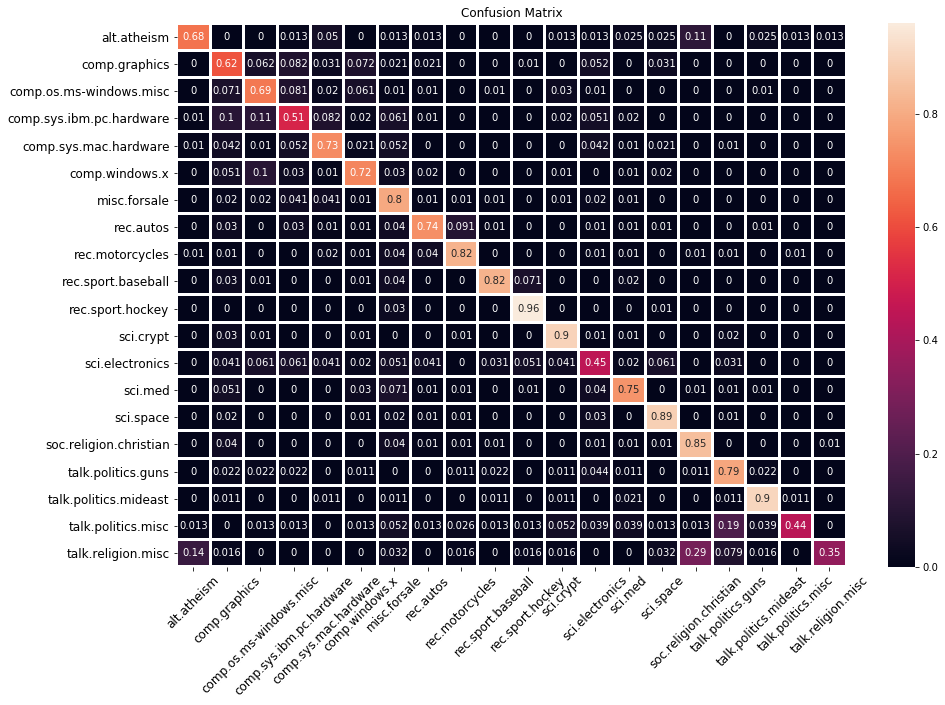

In [16]:
#We create our confusion matrix using the dataframe we extracted before.
matrix = confusion_matrix(y_test,pred_y)
df_conf = pd.DataFrame(matrix, index = names, columns = names)
df_conf = df_conf.div(df_conf.sum(axis=1),axis=0)
#We set the window size
plt.figure(figsize=(15,10))
#We create the heatmap using our dataframe
g = sns.heatmap(df_conf, square=False, linecolor='w',linewidths=2,annot=True)
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 12)
g.set_xticklabels(g.get_xticklabels(), rotation = 45, fontsize = 12)
plt.title('Confusion Matrix')
plt.show()

## Comments

We can see that our results are pretty accurate most of the time.Some categories are more difficult than other since there is pairs of categories that are very close to each other like "talk.politics.misc" and "alt.atheism", the language is similiar for the two topics so it's easier to make classification errors for there topics.


## Analysing features importance

In [19]:
importance = alg.feature_importances_

importance = pd.DataFrame(importance, index=range(0,154036), 
                          columns=["Importance"])

importance["Std"] = np.std([tree.feature_importances_
                            for tree in alg.estimators_], axis=0)

importance_zero = np.count_nonzero(importance['Importance']==0)

importance_zero



135805

In [21]:
importance = importance.sort_values(by=['Importance'],ascending=False)

importance.head(50)

,Importance,Std
45405,0.005664,0.005410
39858,0.004929,0.006335
93537,0.004878,0.004234
48507,0.004762,0.007404
86249,0.004736,0.004634
123866,0.004226,0.006454
118365,0.003882,0.002738
47565,0.003575,0.004305
57996,0.003402,0.003432
82036,0.003077,0.005190


 Here we see that a great number of features have no influance (0 for "feature_importances_") at all in the descision category.These words are most likely to be commun language words like "." ; "," ; "and" etc.. The results are logic because these words equally likely to be found in every article. In the other hand we see that the word with the highest "features_importances_" are words that are very specific to one topic so they have a lot of weight in the decision category.
